##Implement your own SVM

Implement your own linear SVM for the non-separable case.

### a)
Start with writing down the quadratic programming formulation for the dual prob- lem. Describe how you choose $Q$, $c$, $A$, $b$, $A_eq$, $b_eq$.

### Dual problem:

$$\max_{\alpha} \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^n \alpha_i\alpha_j y_i y_j x_i^T x_j$$
$$ \text{s.t.} \quad C \geq \alpha \geq 0 \quad \text{and} \quad \sum_{i=0}^n \alpha_i y_i = 0  $$

### Quadratic programming:

$$ \min_x \frac{1}{2} x^T Q x+ c^T x $$
$$ \text{s.t.} \quad Ax \leq b $$
$$ \text{and} \quad A_{eq}x = b_{eq} $$
$$ \text{and} \quad x_l \leq x \leq x_u $$

### Quadratic problem formulation:
Let $1_n^T$ be a $n$ dimensional ones vector and $Diag(y)$ a $n\times n$ matrix with $y_i$ on the main diagonal and zeros on the remaining positions. 

$$ \min_{\alpha}  \frac{1}{2} \alpha^T Diag(y)XX^T Diag(y) - 1_n^T \alpha$$
$$ \text{s.t.} \quad y^T \alpha = 0 $$
$$ \text{and} \quad 0 \leq \alpha \leq C  $$

The obvious choice for $x$ is $\alpha$.  
$$
\begin{align*}
\text{The obvious choice for } x \text{ is }\alpha \Rightarrow& \quad c = -1_n \quad \text{and} \quad Q = Diag(y)XX^T Diag(y) \\
y^T \alpha = 0 \text{ is a constraint with equality } 
\Rightarrow& \quad A_{eq}= y^T \text{ and } b_{eq} = 0 \\
0 \leq \alpha \leq C \quad \Rightarrow& \quad x_l = 0 \text{ and } x_u = C \\
\text{no more constraints in our problem } \Rightarrow& \quad A = b = []
\end{align*}
$$

$$ w = \sum_{i=1}^n \alpha_i y_i x_i $$

### b)
Write a function that solves the dual problem and returns the parameters w and b. You can e.g. use the method qp from the package CVXOPT 1 to solve the quadratic programming problem

In [1]:
import numpy as np
from cvxopt import solvers
from cvxopt import matrix
from cvxopt.solvers import qp

### SVM

In [2]:
def svm_ns(X, y_np, C):
    # X is a n x d matrix
    n, d = np.shape(X)
    
    y = matrix(y_np)
    diag_y = np.diag(y_np.flatten())
    
    # Q
    Q_half = np.dot(diag_y, X)
    Q = matrix(np.dot(Q_half, Q_half.T), tc = 'd')  
    
    #c
    c = matrix(-1*np.ones((n,1)), tc = 'd')
    
    # 0 <= alpha <= C
    A1 = -1 * np.eye(n)  
    A2 = np.eye(n)
    A  = matrix(np.vstack((A1, A2)), tc = 'd')
    
    b1 = np.zeros((n,1))
    b2 = C * np.ones((n,1))
    b  = matrix(np.vstack((b1,b2)), tc = 'd')
    
    # y^t * alpha = 0 
    A_eq = matrix(y.T, tc = 'd')
    b_eq = matrix([0], tc = 'd')
    
    solvers.options['show_progress'] = False

    # QP
    sol = qp(Q, c, A, b, A_eq, b_eq) 
    
    # alpha
    alpha = np.array(sol['x'])
    
    # w    
    w = np.dot(alpha.T,np.dot(diag_y, X))
    
    # index of support vector
    i = np.argmax(alpha)
    
    # b
    b_ret = 1/y_np[i] - np.dot(w, X.T[:,i])
    
    return(w,b_ret)

### c)
Fit your SVM to the data and find a good value for C. For this it is recommended to split your data into a training set and a test set.

### Data

In [3]:
import pandas as pd
from sklearn.utils import shuffle

data_X = pd.read_csv('data/svm_data.csv', names = ['x1','x2'])
data_y = pd.read_csv('data/svm_labels.csv', names = ['y'])

(data_y_1,data_y_2) = np.split(data_y, 2)
(data_X_1, data_X_2) = np.split(data_X, 2)

X_shuffle_1, y_shuffle_1 = shuffle(data_X_1, data_y_1, random_state = 1234)
X_shuffle_2, y_shuffle_2 = shuffle(data_X_2, data_y_2, random_state = 1234)

X_train_1, X_test_1 = np.split(X_shuffle_1, 2)
X_train_2, X_test_2 = np.split(X_shuffle_2, 2)

y_train_1, y_test_1 = np.split(y_shuffle_1, 2)
y_train_2, y_test_2 = np.split(y_shuffle_2, 2)

y_train = np.vstack((y_train_1, y_train_2)) 
y_test = np.vstack((y_test_1, y_test_2))

X_train = np.vstack((X_train_1, X_train_2))
X_test = np.vstack((X_test_1, X_test_2))

### Test error

In [4]:
def err_svm(X,y,w,b):
    n = len(y)
    pred = np.dot(w, X.T) + np.ones((1,n))*b
    y_pred = np.zeros(n)
    miss = 0
  
    for i in range(n):
        y_pred[i] = -1

        if(pred[0,i] >= 0):
            y_pred[i] = 1

        if(y_pred[i] != y[i]):
            miss = miss + 1
            
    return (miss/n)

### Fitting the model

In [5]:
err = np.zeros(1000)

# 0 <= C <= 500 
w = np.vstack((np.zeros(1000),np.zeros(1000))).T

b = np.zeros(1000)
for i in range(1000):
    w[i],b[i] = svm_ns(X_train, y_train, i/2)
    err[i] = err_svm(X_train, y_train, w[i,:],b[i])



In [6]:
C_min = np.argmin(err)

print('C: ', C_min)
print('training error:',err_svm(X_train, y_train, w[C_min],b[C_min]))
print('test error:',err_svm(X_test, y_test, w[C_min],b[C_min]))

print('w:', w[C_min])
print('b', b[C_min])


C:  558
training error: 0.03
test error: 0.08
w: [-2.97946865 -2.07783373]
b 14.430845626572832


### d)
Visualize the training data and plot the decision boundary.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

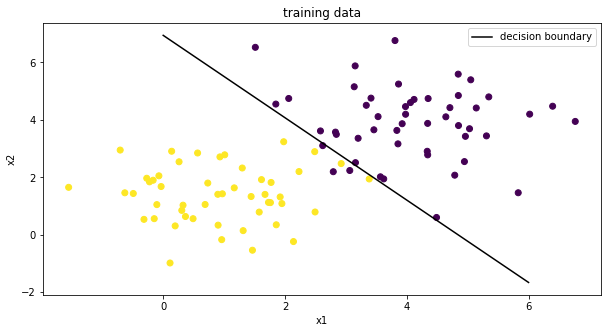

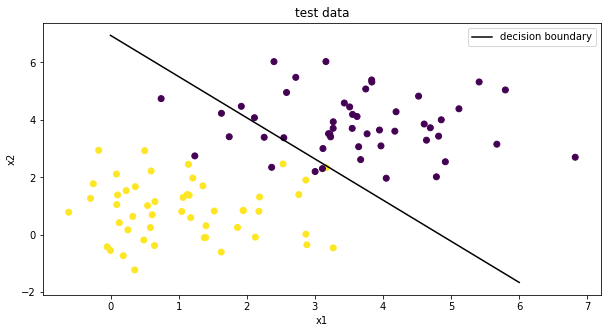

In [8]:
# training data and decision boundary
plt.figure(figsize=(10,5))

# training data
plt.scatter(X_train[:,0], X_train[:,1], c = y_train.ravel())

# decision boundary
slope = -w[C_min].T[0] / w[C_min].T[1]
intercept = -b[C_min] / w[C_min].T[1]
x = np.arange(0, 7)
plt.plot(x, x * slope + intercept, 'k-', label = 'decision boundary')

plt.title('training data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()


# test data and decision boundary
plt.figure(figsize=(10,5))

# test data 
plt.scatter(X_test[:,0], X_test[:,1], c = y_test.ravel())

# decision boundary
plt.plot(x, x * slope + intercept, 'k-', label = 'decision boundary')

plt.title('test data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()


